<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/CNN/DUDL_CNN_EMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import and inspect the data

In [3]:
# Download the dataset
cdata = torchvision.datasets.EMNIST(root='emnist', split='letters', download=True)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


In [5]:
# INSPECT THE DATA

# The categories
print(cdata.classes)
print(f'{len(cdata.classes)} classes')
print(f'\nData size: {cdata.data.shape}')

# Transform to 4D tensor for conv layer (and transform from int8 to float)
images = cdata.data.view([124800, 1, 28, 28]).float()
print(f'Tensor data: {images.shape}')

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size: torch.Size([124800, 28, 28])
Tensor data: torch.Size([124800, 1, 28, 28])


In [6]:
# brief aside: class 'N/A' doesn't exist in the data.
print( torch.sum(cdata.targets==0) )

# However, it causes problems in one-hot encoding...
torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [7]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [8]:
# Eliminate the N/A and subtract 1 from the original
# Remove the first class category
letter_categories = cdata.classes[1:]

# Relabel labels to start at 0
labels = copy.deepcopy(cdata.targets) - 1
print(labels.shape)

print(torch.sum(labels == 0))
print(torch.unique(labels))

torch.Size([124800])
tensor(4800)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])


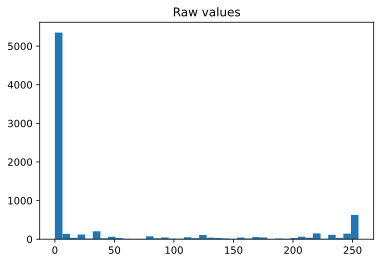

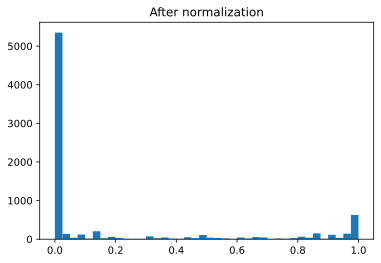

In [9]:
# next issue: do we need to normalize the images?
plt.hist(images[:10, :, :, :].view(1, -1).detach(), 40);
plt.title('Raw values')
plt.show()

# yarp.
images /= torch.max(images)

plt.hist(images[:10, :, :, :].view(1, -1).detach(), 40);
plt.title('After normalization')
plt.show()

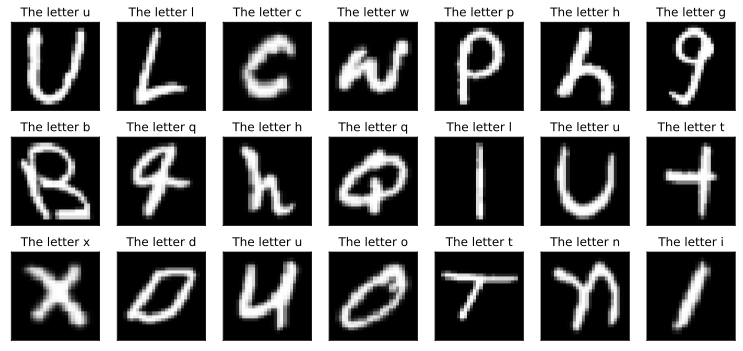

In [10]:
# Visualize some images
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axs.flatten()):

    # Pick a random pic
    which_pic = np.random.randint(images.shape[0])

    # Extract the image and its target letter
    I      = np.squeeze(images[which_pic, :, :])
    letter = letter_categories[labels[which_pic]]
    
    # Visualize
    ax.imshow(I.T, cmap='gray')
    ax.set_title(f'The letter {letter}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Create train/test groups using DataLoader

In [11]:
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data,  test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                        shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                        batch_size=test_data_set.tensors[0].shape[0])

In [12]:
# Check size (should be images X channels X width X height
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


# Create the DL model

In [13]:
def make_the_net(print_toggle=False):
    """
    CNN_EMNIST
    """
    class emnist_net(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            self.print = print_toggle

            ######################## FEATURE MAP LAYERS ########################
            self.conv1  = nn.Conv2d(1, 6, kernel_size=3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(num_features=6)
                # (28 + 2*1 - 3)/1 + 1 = 28/2 = 14
            
            self.conv2  = nn.Conv2d(6, 6, kernel_size=3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(num_features=6)
                # (14 + 2*1 - 3)/1 + 1 = 14/2 = 7

            ######################## LINEAR DECISION LAYERS ####################
            self.fc1 = nn.Linear(7 * 7 * 6, 50)
            self.fc2 = nn.Linear(50, 26)
        
        def forward(self, x):
            # Convolution -> Maxpool -> Batchnorm -> Relu
            if self.print:    print(f'Input:            {list(x.shape)}')

            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print:    print(f'First CPR Block:  {list(x.shape)}')

            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print:    print(f'Second CPR Block: {list(x.shape)}')

            # Reshape for linear layer
            n_units = x.shape.numel() / x.shape[0]
            x       = x.view(-1, int(n_units))
            if self.print:    print(f'Vectorized:       {list(x.shape)}')

            # Linear layer
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)
            if self.print:    print(f'Final output:     {list(x.shape)}')

            return x
    
    # Create the model instance
    net = emnist_net(print_toggle)

    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, loss_func, optimizer

In [14]:
# Test the model with one batch
net, loss_func, optimizer = make_the_net(print_toggle=True)

X, y = iter(train_loader).next()
y_hat = net(X)

print(''), print(f'Output size: {y_hat.shape}')

loss = loss_func(y_hat, torch.squeeze(y))
print(''), print(f'Loss: {loss}')

Input:            [32, 1, 28, 28]
First CPR Block:  [32, 6, 14, 14]
Second CPR Block: [32, 6, 7, 7]
Vectorized:       [32, 294]
Final output:     [32, 26]

Output size: torch.Size([32, 26])

Loss: 3.195525884628296


(None, None)

# Create a function that trains the model

In [15]:
def train_the_model():
    """
    CNN_EMNIST
    """
    
    num_epochs = 10

    # Create a new model
    net, loss_func, optimizer = make_the_net()

    # Initialize
    train_loss = torch.zeros(num_epochs)
    test_loss  = torch.zeros(num_epochs)
    train_err  = torch.zeros(num_epochs)
    test_err   = torch.zeros(num_epochs)

    # Send the model to the GPU
    net.to(device)

    # Loop over epochs
    for epoch_i in range(num_epochs):
        net.train()

        # Loop over training data batches
        batch_err  = []
        batch_loss = [] 

        for X, y in train_loader:

            # Push data to GPU
            X = X.to(device)
            y = y.to(device)

            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and Error from this batch
            batch_loss.append(loss.item())
            batch_err .append(torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item())

        # End of batch loop.

        # Get the average training accuracy of the batches
        train_loss[epoch_i] = np.mean(batch_loss)
        train_err [epoch_i] = 100 * np.mean(batch_err)

        # Test accuracy
        net.eval()
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        
        # Push data to GPU
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_hat = net(X)
            loss  = loss_func(y_hat, y)
            
        test_loss[epoch_i] = loss.item()
        test_err     [epoch_i] = 100 * torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item()

    # End epochs

    return train_loss, test_loss, train_err, test_err, net

# Run the model and show the results!

In [16]:
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
train_loss, test_loss, train_err, test_err, net = train_the_model()

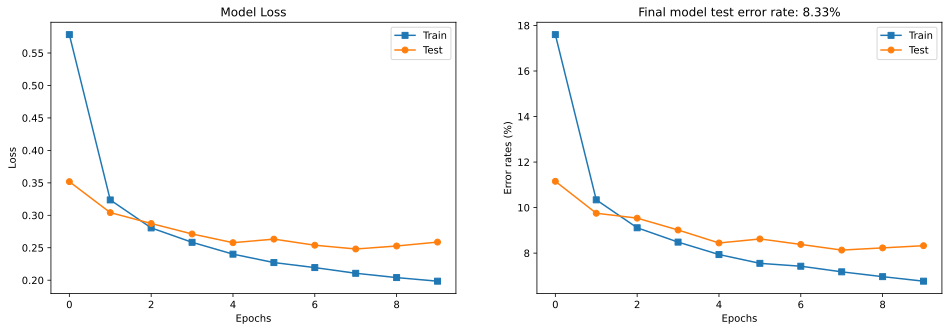

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-', label='Train')
ax[0].plot(test_loss,  'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend()

ax[1].plot(train_err, 's-', label='Train')
ax[1].plot(test_err,  'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {test_err[-1]:.2f}%')
ax[1].legend()

plt.show()

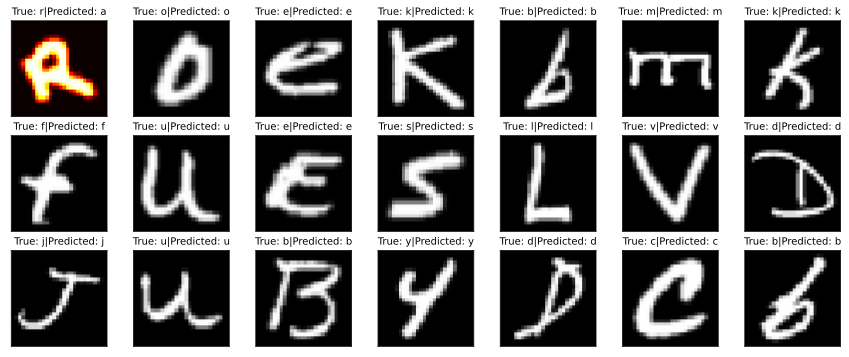

In [18]:
# Visualize some images

# Extract X, y from test dataloader
X, y = next(iter(test_loader))
# Push data to GPU
X     = X.to(device)
y     = y.to(device)
y_hat = net(X)

# Pick some examples at random to show
rand_idx = np.random.choice(len(y), size=21, replace=False)

fig, axs = plt.subplots(3, 7, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    # Extract the image and its target letter
    I           = np.squeeze(X[rand_idx[i], 0, :, :]).cpu()
    true_letter = letter_categories[y[rand_idx[i]]]
    pred_letter = letter_categories[torch.argmax(y_hat[rand_idx[i], :])]

    # Color-code the accuracy
    col = 'gray' if (true_letter == pred_letter) else 'hot'

    # Visualize
    ax.imshow(I.T, cmap=col)
    ax.set_title(f'True: {true_letter}|Predicted: {pred_letter}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Accuracy by letter

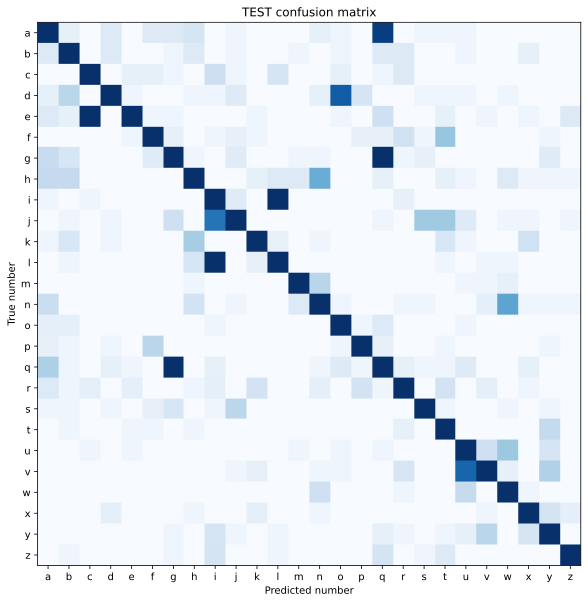

In [19]:
# ACCURACY BY LETTER
import sklearn.metrics as skm

# Confusion matrix
C = skm.confusion_matrix(y_true=y.cpu(), y_pred=torch.argmax(y_hat.cpu(), axis=1), normalize='true')

# Visualize
fig = plt.figure(figsize=(10, 10))
plt.imshow(C, 'Blues', vmax=0.05)

plt.xticks(range(26), labels=letter_categories)
plt.yticks(range(26), labels=letter_categories)
plt.title('TEST confusion matrix')
plt.ylabel('True number')
plt.xlabel('Predicted number')
plt.show()

# Additional explorations

In [ ]:
# 1) I added batch normalization to the convolution layers, but not to the linear (fc*) layers. But linear layers also 
#    benefit from batchnorm just like convolution layers do. Add it!
# 
# 2) In the next few videos, we will see whether we can improve the model's performance by experimenting with the number
#    of layers, kernel size, and linear-layer units. Is there anything you could think of, other than these three features,
#    that might help boost model performance?
# 